# Autoencoder Cifar-10 dataset
Deze auto encoder gaat vooral over de praktijk zijn. In de readme kan je een link vinden naar de theorie.
De voornaamste focus is om noise te reduceren.

In [106]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd




##Functies unpickelen data

In [107]:
from tensorflow.python.keras import Sequential, Input, Model
from tensorflow.python.keras.activations import softmax
from tensorflow.python.keras.layers import Conv2D, ReLU, BatchNormalization, Conv2DTranspose, Activation, Concatenate
from tensorflow.python.keras.optimizer_v2.adam import Adam

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [108]:
def load_train():
    unpict = unpickle("./cifar-10-batches-py/data_batch_2")
    x = unpict.get(b'data')
    for i in range(2,6):
        unpict = unpickle("./cifar-10-batches-py/data_batch_" + str(i))
        x = np.concatenate((x,np.array(unpict.get(b'data'))))
    return x
def load_test():
    unpict = unpickle("./cifar-10-batches-py/test_batch")
    x = unpict.get(b'data')
    return x
def values_to_image(x):
    new_array =[]
    for i in range(0,len(x)):
        img_flat = x[i]
        img_R = img_flat[0:1024].reshape((32, 32))
        img_G = img_flat[1024:2048].reshape((32, 32))
        img_B = img_flat[2048:3072].reshape((32, 32))
        new_array.append(np.dstack((img_R, img_G, img_B)))
    return np.array(new_array)
def normalize_values(data, amount):
    newValues = []
    for i in range(0,len(data)):
        newValues.append(data[i]/amount)
    return np.array(newValues)

# Noise maker
def add_noise(data):
    noise = np.random.normal(0,0.1,data.shape)
    data = data + noise
    data = np.clip(data,0.,1.)
    return data


## Maken Encoder/Decoder
Ik probeer hem zo univserseel mogelijk te maken zodat ik het ook mogelijk later nog kan gebruiken voor andere projecten
zonder veel te moeten veranderen

In [109]:
def conv_model_block(x, filters, kernel_size, strides=2):
    x = Conv2D(filters=filters,kernel_size=kernel_size,strides=strides,padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x
def deconv_model_block(x,filters,kernel_size):
    x = Conv2DTranspose(filters=filters, kernel_size=kernel_size,strides=2,padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x

def compare_images(image1,image2):
    plt.subplot(1,2,1)
    plt.imshow(image1[0])
    plt.title(image1[1])
    plt.subplot(1,2,2)
    plt.imshow(image2[0])
    plt.title(image2[1])
    plt.show()

## Laad data

In [110]:
train = values_to_image(load_train())
test = values_to_image(load_test())

# Gebruik noise

In [111]:
train = train / 255
test = test / 255
y_train = train
X_train = add_noise(train)

y_test = test
X_test = add_noise(test)

## plot image

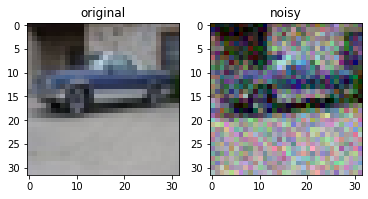

In [112]:
compare_images([y_train[0],"original"],[X_train[0],"noisy"])

## Maak model
Hier worden 4 encode lagen voor gebruikt en 3 decode lagen

In [113]:
inputs = Input(shape=(32, 32, 3))
c1 = conv_model_block(inputs,32,3)
c2 = conv_model_block(c1,64,3)
c3 = conv_model_block(c2,128,3)
c4 = conv_model_block(c3,256,3)
c5 = conv_model_block(c4,256,3,1)

d1 = deconv_model_block(c5,256,3)
m1 = Concatenate()([d1,c3])
d2 = deconv_model_block(m1,128,3)
m2 = Concatenate()([d2,c2])
d3 = deconv_model_block(m2,64,3)
m3 = Concatenate()([d3,c1])
d4 = deconv_model_block(m3,32,3)

conv = Conv2DTranspose(filters=3,kernel_size=3,padding='same')(d4)
outputs = Activation('sigmoid')(conv)
model = Model(inputs=inputs,outputs=outputs)

In [114]:
model.compile(optimizer=Adam(0.01), metrics=['accuracy'], loss='mean_squared_error')
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_48 (Conv2D)              (None, 16, 16, 32)   896         input_13[0][0]                   
__________________________________________________________________________________________________
batch_normalization_79 (BatchNo (None, 16, 16, 32)   128         conv2d_48[0][0]                  
__________________________________________________________________________________________________
re_lu_79 (ReLU)                 (None, 16, 16, 32)   0           batch_normalization_79[0][0]     
____________________________________________________________________________________________

zonder concatenate
[image](./img.png)

# Train model

In [115]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=40, batch_size=128)

Epoch 1/40
391/391 [==============================] - 11s 24ms/step - loss: 0.0086 - accuracy: 0.6344 - val_loss: 0.0028 - val_accuracy: 0.7658

In [118]:
predictions = model.predict(X_test)

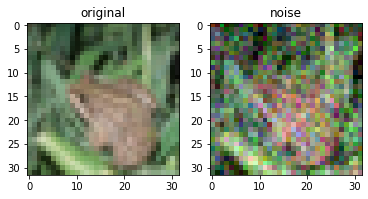

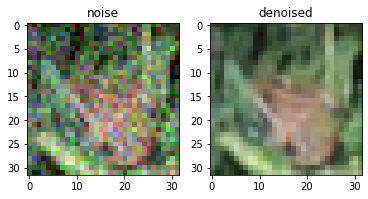

In [119]:
compare_images([y_test[4], "original"],[X_test[4],'noise'])
compare_images([X_test[4],"noise"],[predictions[4],"denoised"])

## Conclusion
Zoals je kan zien kan de test set 